## Imports

In [4]:
import os
import sys
import pandas as pd
import seaborn as sns

from typing import List


# Importing functions from src/data
parent_dir = os.path.abspath(os.path.join('..'))
module_path = parent_dir + "/src/data"

if module_path not in sys.path:
    sys.path.append(module_path)

import database as db
import api
import pickle_helpers as pkle
import constants as cnt

## Table of Contents

1. [Data Collection](#data-collection)
2. [Data Validation](#data-validation)
3. [Preprocessing](#preprocessing)

### Data Collection

The average price is collected from an API and stored in a postgresql database. In order to retrieve the data in order to begin any analysis we make a query to the database which is handled by the market_data function below.

The data recieved is in the format of a list of 3-tuples containing a unique id, time and price at that time.

In [5]:
# TODO: Improve function to follow dry principles
def create_item_dataframe(raw_material_name: str, region_id: str | int = "0"):
    
    # Historical average buy and sell order stats for raw_material_name
    buy_market_stats = api.market_data(raw_material_name, region_id=region_id)
    buy_order_stats = [i[2] for i in buy_market_stats]
    times = [i[1] for i in buy_market_stats]
    
    sell_market_stats = api.market_data(raw_material_name, region_id=region_id, order_type="sell")
    sell_order_stats = [i[2] for i in sell_market_stats]
    times = [i[1] for i in sell_market_stats]

    # Creating dataframe for buy and sell orders and renaming columns
    df_buy = pd.DataFrame(data=buy_order_stats)
    df_buy.rename(columns=lambda x: "buy_" + x, inplace=True)
    
    df_sell = pd.DataFrame(data=sell_order_stats)
    df_sell.rename(columns=lambda x: "sell_" + x, inplace=True)
    
    df_times = pd.DataFrame(data=times, columns=["time"])

    df = pd.concat([df_times, df_buy, df_sell], axis=1)

    return df

def create_item_plot(raw_material_name: str, region_id: str = "0", order_type: str = "both"):
    
    df = create_item_dataframe(raw_material_name, region_id=region_id)
    

    # Fixing datatype for all the columns except the time column
    for i in df.iloc[:,1:].columns:
        df[i] = pd.to_numeric(df[i])
    
    if order_type == "both":
        cols = ['time', 'buy_median', 'buy_weightedAverage', 'sell_median', 'sell_weightedAverage']
    elif order_type == "sell":
        cols = ['time', 'sell_median', 'sell_weightedAverage']
    elif order_type == "buy":
        cols = ['time', 'buy_median', 'buy_weightedAverage']
        
    df = df[cols]
    data = pd.melt(df, ["time"])
        
    # Plot
    sns.set_theme(style="white")
    plt = sns.lineplot(data=data, x='time', y='value', hue='variable')
    plt.set(title=f"The Price of {raw_material_name}", ylabel="Price (ISK)")
    

Command executed successfully
Command executed successfully


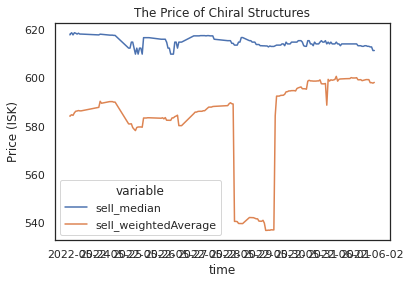

In [6]:
#market_data("Silicon", "0", order_type="sell")
#create_item_dataframe("Silicon", "0")

create_item_plot("Chiral Structures", "0", "sell")

In [7]:
# Return the current price of a material in all regions
def current_price(material_name: str, region_id: int | str = "all", order_type: str = "buy"):
    """_summary_

    Args:
        material_name (str): _description_
        region_id (int | str, optional): _description_. Defaults to "all".
        order_type (str, optional): _description_. Defaults to "buy".
    """
    
    item_id = api.get_item_id(material_name)
    
    command = (f"""
        SELECT data -> '{item_id}' -> '{order_type}'
        FROM market_data
        WHERE region_id = {region_id}
    """)
    
# Determine how much an item has increased by given a time frame
def compute_percentage_gain(material_name: str, region_id: str | int, order_type):
    pass
